In [1]:
import sklearn as skl
import pickle as pkl
import pandas as pd
import numpy as np

import sklearn.model_selection
import sklearn.svm
import sklearn.metrics

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import seaborn as sns

from itertools import chain

In [2]:
import scipy as sp

In [3]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

In [4]:
import sys
sys.path.append("..") # or wherever the package is
import kuanglu

In [5]:
import scanpy as sc

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

## Create dataloaders

Note: samples must have the same number of genes (and of course in the same order). They can, however, have different number of cells, but you'll only be able to use `batch_size = 1`, because we matrices with different sizes cannot form a tensor.

It is possible in the future, by flanking them with zeros and carefully masking them out in several steps.

In [7]:
adata = sc.read_h5ad('data/demo1_sp_adata.h5ad')

train_Xs = []
chosen_slices = ['MsBrainAgingSpatialDonor_5_0', 'MsBrainAgingSpatialDonor_6_0', 
                 'MsBrainAgingSpatialDonor_7_0']
for i in chosen_slices:
    train_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
validate_Xs = []
chosen_donors = ['MsBrainAgingSpatialDonor_8_0']
for i in chosen_donors:
    validate_Xs.append(np.array(adata.X[adata.obs['donor_slice'] == i, :]))
    
_, p = train_Xs[0].shape

class MyDataSet(Data.Dataset):
    def __init__(self, Xs):
        super(MyDataSet, self).__init__()
        self.Xs = [torch.Tensor(X) for X in Xs]
        
    def __len__(self):
        return len(self.Xs)

    def __getitem__(self, idx):
        return self.Xs[idx]

train_data = MyDataSet(train_Xs)
train_loader = Data.DataLoader(train_data, batch_size=1, shuffle=True) 

print("Training data dimensions:")
for i in train_Xs:
    print(i.shape)

validate_data = MyDataSet(validate_Xs)
validate_loader = Data.DataLoader(validate_data, batch_size=1, shuffle=True)

print("Validation data dimensions:")
for i in validate_Xs:
    print(i.shape)

Training data dimensions:
(5000, 374)
(5000, 374)
(5000, 374)
Validation data dimensions:
(5000, 374)


In [8]:
embed_config = {
    'embedType': 'transformer',
    'default': True,
    'd_input': p,
    'n_layers': 1,
}

model = kuanglu.Model(d_gene=p, 
                      d_denoise = [p], 
                      d_quality=[512, 256, 1], 
                      lbd=1.,
                      embed_config=embed_config,
                      ).to('cuda')

In [9]:
rec = model.fit('denoised', train_loader, validate_loader, [0, 500],
                fix=['embed', 'qualify', 'smooth', 'interact'], lr=1e-4)
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [500, 750],
                                           fix=['denoise', 'interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('smoothed', train_loader, validate_loader, [750, 1000],
                                           fix=['interact'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1000, 1250],
                                           fix=['denoise', 'embed', 'qualify', 'smooth'], lr=1e-4))
rec = kuanglu.record_concat(rec, model.fit('final', train_loader, validate_loader, [1250, 1500], lr=1e-4))


/home/caoyufan/kuanglu/examples/../kuanglu/model.py:312: UserWarning: Parameter containing:
tensor(100., device='cuda:0') is already fixed. They will be unfixed when exiting this function.
  warnings.warn(f"{param} is already fixed. They will be unfixed when exiting this function.")


Epoch 0001 Train MSE 0.965 Validate MSE 1.059 Raw MSE 1.034
Epoch 0002 Train MSE 0.987 Validate MSE 1.037 Raw MSE 1.018
Epoch 0003 Train MSE 0.974 Validate MSE 1.055 Raw MSE 1.032
Epoch 0004 Train MSE 0.966 Validate MSE 1.034 Raw MSE 1.011
Epoch 0005 Train MSE 0.961 Validate MSE 1.035 Raw MSE 1.018
Epoch 0006 Train MSE 0.964 Validate MSE 1.018 Raw MSE 0.994
Epoch 0007 Train MSE 0.966 Validate MSE 1.034 Raw MSE 1.015
Epoch 0008 Train MSE 0.949 Validate MSE 1.023 Raw MSE 1.003
Epoch 0009 Train MSE 0.955 Validate MSE 1.037 Raw MSE 1.017
Epoch 0010 Train MSE 0.948 Validate MSE 1.054 Raw MSE 1.030
Epoch 0011 Train MSE 0.947 Validate MSE 1.010 Raw MSE 0.986
Epoch 0012 Train MSE 0.948 Validate MSE 1.038 Raw MSE 1.015
Epoch 0013 Train MSE 0.942 Validate MSE 1.014 Raw MSE 0.995
Epoch 0014 Train MSE 0.962 Validate MSE 1.033 Raw MSE 1.013
Epoch 0015 Train MSE 0.940 Validate MSE 1.040 Raw MSE 1.020
Epoch 0016 Train MSE 0.946 Validate MSE 1.016 Raw MSE 0.995
Epoch 0017 Train MSE 0.966 Validate MSE 

Text(0, 0.5, 'MSE')

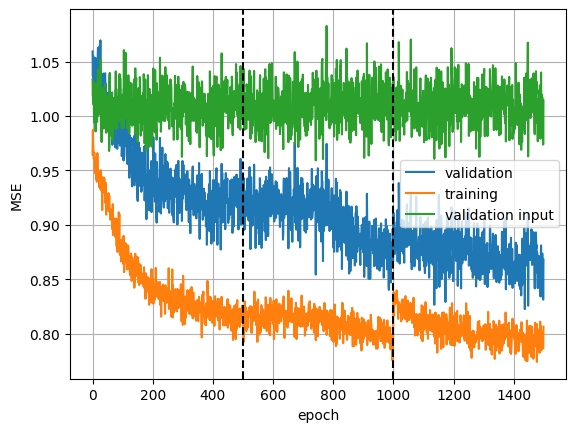

In [10]:
plt.plot(rec['validate_epoch'], rec['validate_mse'], label='validation')
plt.plot(rec['train_epoch'], rec['train_mse'], label='training')
plt.plot(rec['validate_epoch'], rec['raw_mse'], label='validation input')
plt.legend()
plt.grid()
plt.axvline(500, ls='--', c='k')
plt.axvline(1000, ls='--', c='k')
plt.xlabel('epoch')
plt.ylabel('MSE')

In [11]:
mse_df = pd.DataFrame({'epoch': rec['validate_epoch'], 'mse': rec['validate_mse']})

def epoch2stage(x):
    if x < 250: return 'pre-denoise'
    elif x < 500: return 'denoise'
    elif x < 750: return 'pre-denoise-smooth'
    elif x < 1000: return 'denoise-smooth'
    elif x < 1250: return 'pre-denoise-smooth-enhance'
    elif x < 1500: return 'denoise-smooth-enhance'
    else: raise NotImplementedError('x >= 1500 not allowed')

mse_df['stage'] = mse_df['epoch'].apply(epoch2stage)
mse_df

epoch       mse                   stage
0         0  1.059487             pre-denoise
1         1  1.036564             pre-denoise
2         2  1.055382             pre-denoise
3         3  1.033966             pre-denoise
4         4  1.034928             pre-denoise
...     ...       ...                     ...
1495   1495  0.873679  denoise-smooth-enhance
1496   1496  0.849305  denoise-smooth-enhance
1497   1497  0.865993  denoise-smooth-enhance
1498   1498  0.831260  denoise-smooth-enhance
1499   1499  0.868041  denoise-smooth-enhance

[1500 rows x 3 columns]

/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


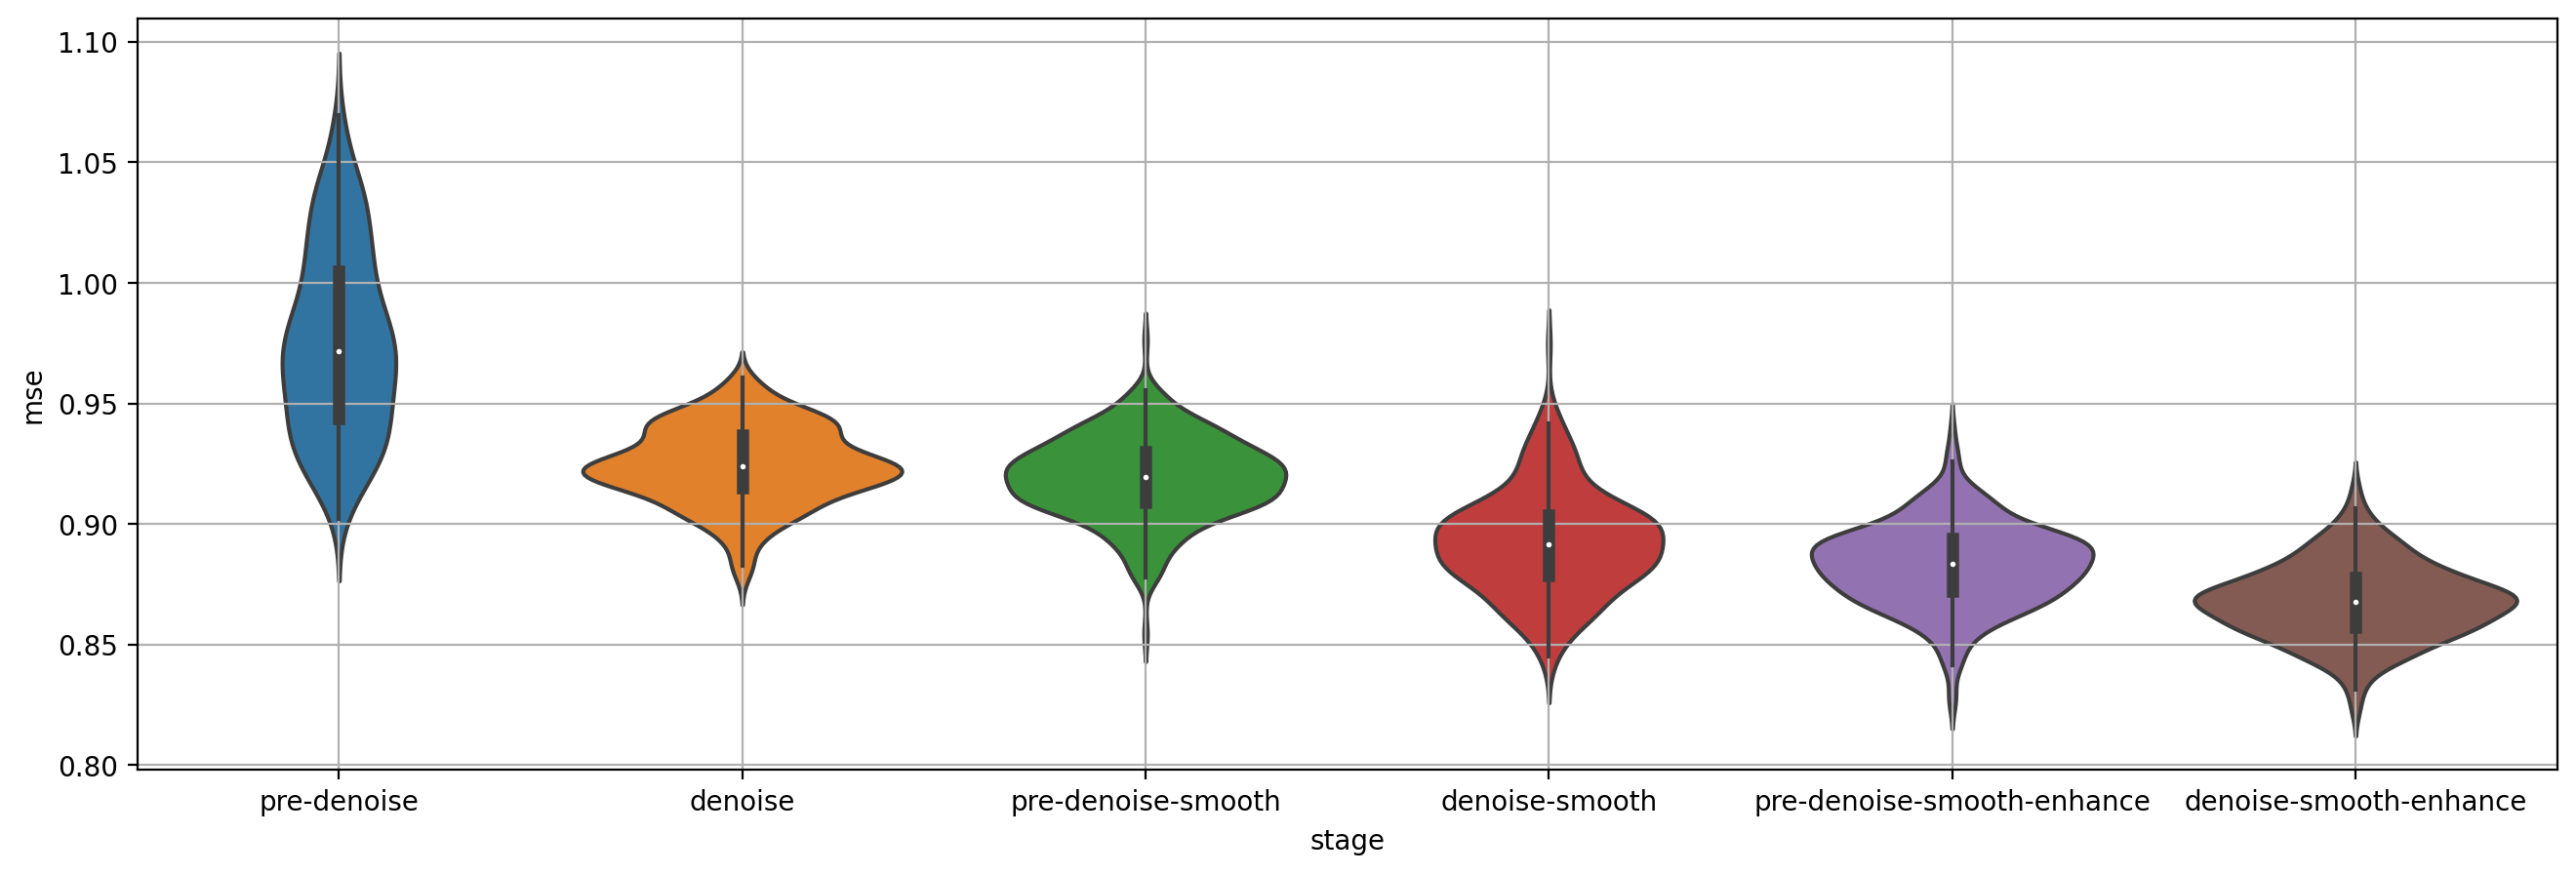

In [12]:
# sns.violinplot(mse_df[~mse_df['stage'].str.contains('pre-')], x='stage', y='mse')
%config InlineBackend.figure_format ='retina'
plt.figure(figsize=(16, 5))
sns.violinplot(mse_df, x='stage', y='mse')
plt.grid()

In [13]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'])

print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise') / sum(mse_df['stage'] == 'denoise-smooth'))

p = 2.8853061004824878e-49 f = 0.881344


In [14]:
u_stat, p_val = sp.stats.mannwhitneyu(mse_df.loc[mse_df['stage'] == 'denoise-smooth', 'mse'], 
                      mse_df.loc[mse_df['stage'] == 'denoise-smooth-enhance', 'mse'])
print('p =', p_val, 
      'f =', u_stat / sum(mse_df['stage'] == 'denoise-smooth') / sum(mse_df['stage'] == 'denoise-smooth-enhance'))

p = 6.562115827819996e-36 f = 0.8233440000000001


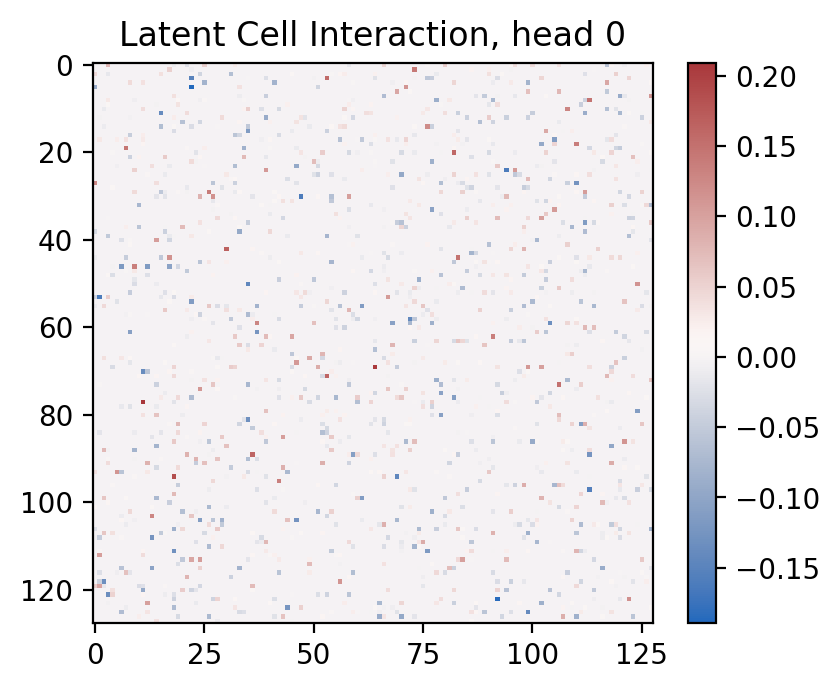

In [15]:
# Plot heatmap of the parameters in cell interaction module

weight_CIs = []
for head in range(len(model.cell_interacts)):
    weight_CIs.append(model.cell_interacts[head].transform.data)

plt.figure(figsize=(10, 8))
for i, weight_CI in enumerate(weight_CIs):
    weight_array = weight_CI.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag')
    plt.colorbar()
    plt.title(f'Latent Cell Interaction, head {i}')
plt.show()

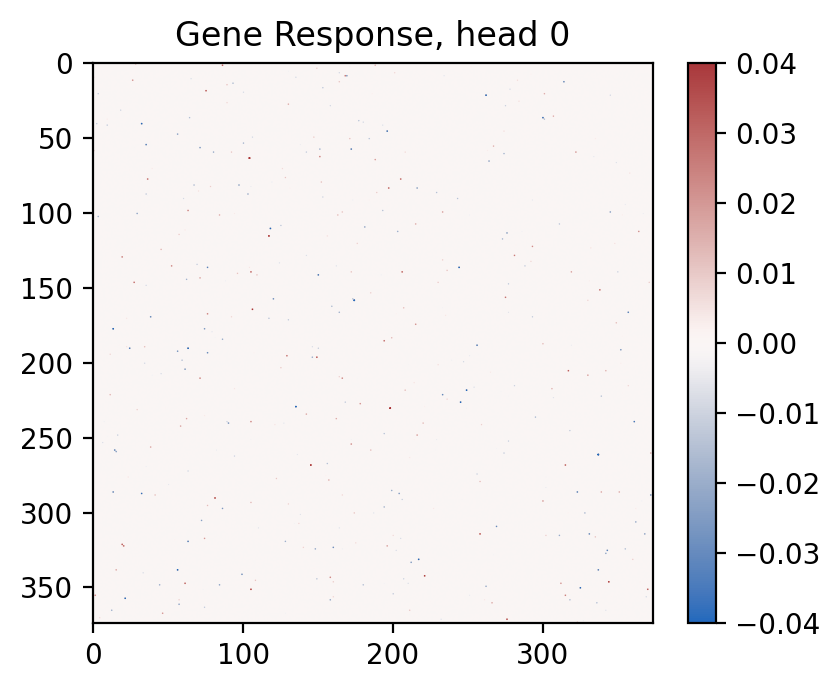

In [16]:
# Plot heatmap of the parameters in gene response module

weight_GRs = []
for head in range(len(model.cell_interacts)):
    weight_GRs.append(model.cell_interacts[head].gene_response.data)

plt.figure(figsize=(10, 8))
for i, weight_GR in enumerate(weight_GRs):
    weight_array = weight_GR.cpu().numpy()
    plt.subplot(2, 2, i + 1)
    plt.imshow(weight_array, cmap='vlag', vmin=-.04, vmax=.04)
    plt.colorbar()
    plt.title(f'Gene Response, head {i}')
plt.show()

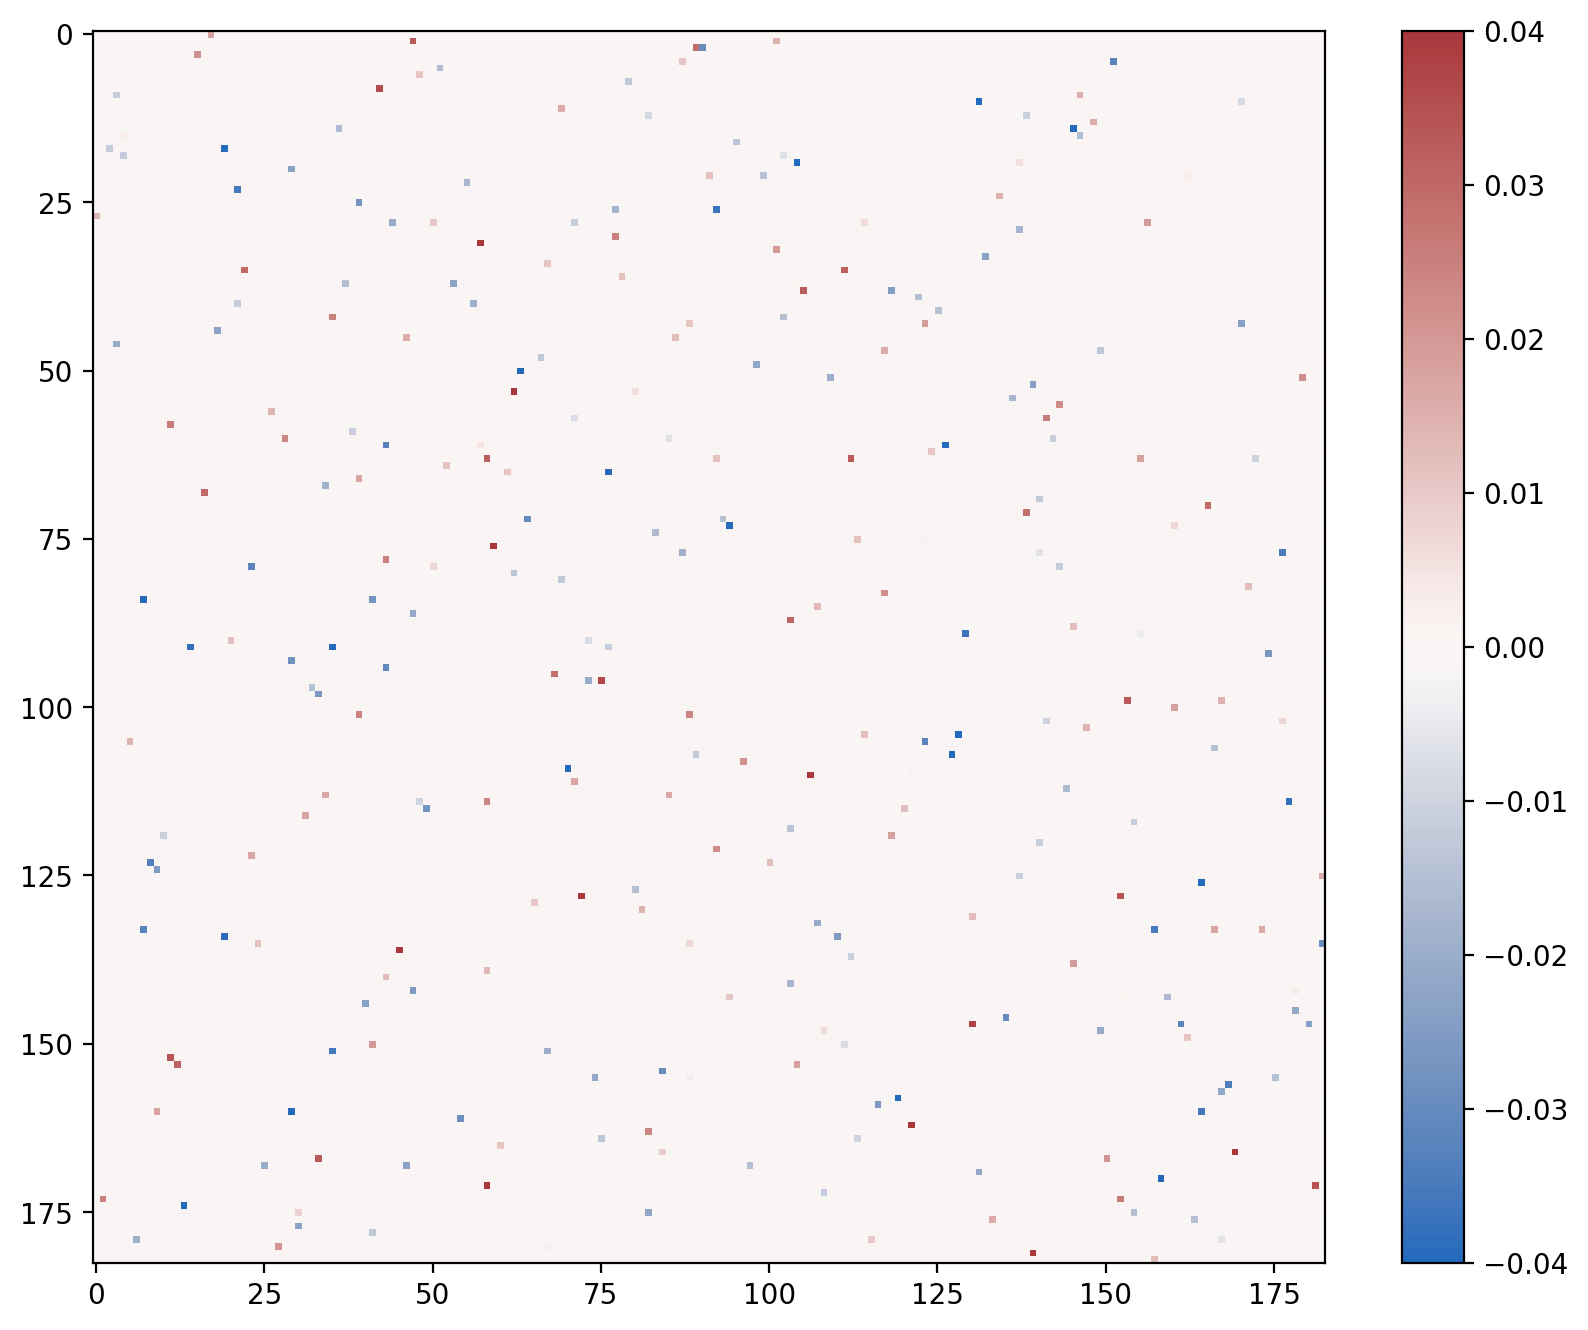

In [17]:
# Extract meaningful weights from Gene Response
THRESHOLD = 0.01

matGR = model.cell_interacts[0].gene_response.data.cpu().numpy()
col_max = np.max(np.abs(matGR), axis=0)
row_max = np.max(np.abs(matGR), axis=1)

meaningfulCols = np.where(col_max > THRESHOLD)[0]
meaningfulRows = np.where(row_max > THRESHOLD)[0]

meaningfulMatGR = matGR[meaningfulRows, :][:, meaningfulCols]

# meaningfulMatGR = np.clip(meaningfulMatGR, -.04, .04)

plt.figure(figsize=(10, 8))
plt.imshow(meaningfulMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()

In [18]:
# Find the indices of highest absolute values in the meaningfulMatGR

topK = 10
topK_indices = np.argsort(np.abs(matGR), axis=None)[-topK:]

topK_indices = np.unravel_index(topK_indices, matGR.shape)

topK_indices

(array([ 40, 110, 115, 177, 268, 229, 158, 230, 261,  63]),
 array([ 32, 118, 117,  13, 145, 135, 174, 198, 337, 104]))

In [19]:
np.abs(matGR)[topK_indices]

array([0.05141487, 0.0532166 , 0.05328658, 0.05529355, 0.05531265,
       0.06010531, 0.07707572, 0.08771282, 0.1033669 , 0.10856087],
      dtype=float32)

In [20]:
# check the corresponding genes

LR_pairs = []

for i in range(topK):
    LR_pairs.append((adata.var.index[topK_indices[1][i]], 
                     adata.var.index[topK_indices[0][i]]))

LR_pairs

[('ENSMUSG00000044303', 'ENSMUSG00000037242'),
 ('ENSMUSG00000003184', 'ENSMUSG00000026770'),
 ('ENSMUSG00000003882', 'ENSMUSG00000036117'),
 ('ENSMUSG00000028487', 'ENSMUSG00000019935'),
 ('ENSMUSG00000022206', 'ENSMUSG00000039683'),
 ('ENSMUSG00000041607', 'ENSMUSG00000023067'),
 ('ENSMUSG00000000753', 'ENSMUSG00000038151'),
 ('ENSMUSG00000034324', 'ENSMUSG00000034640'),
 ('ENSMUSG00000021670', 'ENSMUSG00000061911'),
 ('ENSMUSG00000025929', 'ENSMUSG00000021478')]

In [21]:
import pandas as pd

lr_pairs = pd.read_csv('./mouse_lr_pair.csv')

lgID = lr_pairs['ligand_ensembl_gene_id']
rpID = lr_pairs['receptor_ensembl_gene_id']

lrID = pd.concat([lgID, rpID], axis=1)
# lrID

geneIDBank = set(adata.var.index)

# filter out the genes that are not in the dataset

lrID = lrID[lrID['ligand_ensembl_gene_id'].isin(geneIDBank) &
            lrID['receptor_ensembl_gene_id'].isin(geneIDBank)]
lrID

ligand_ensembl_gene_id receptor_ensembl_gene_id
26       ENSMUSG00000035385       ENSMUSG00000049103
50       ENSMUSG00000000869       ENSMUSG00000026770
52       ENSMUSG00000000869       ENSMUSG00000031304
275      ENSMUSG00000017344       ENSMUSG00000026768
323      ENSMUSG00000019772       ENSMUSG00000022206
334      ENSMUSG00000019997       ENSMUSG00000020122
339      ENSMUSG00000019997       ENSMUSG00000030786
467      ENSMUSG00000024164       ENSMUSG00000026616
469      ENSMUSG00000024164       ENSMUSG00000030724
470      ENSMUSG00000024164       ENSMUSG00000030786
1144     ENSMUSG00000024164       ENSMUSG00000000290
1153     ENSMUSG00000051439       ENSMUSG00000000290
1212     ENSMUSG00000049796       ENSMUSG00000003476
1296     ENSMUSG00000019772       ENSMUSG00000011171
1356     ENSMUSG00000025746       ENSMUSG00000020122
1357     ENSMUSG00000028364       ENSMUSG00000020122
1473     ENSMUSG00000002985       ENSMUSG00000023992
1557     ENSMUSG00000028364       ENSMUSG00000026768
1653     ENSMUSG00000002985       ENSMUSG00000015243
1900     ENSMUSG00000066551       ENSMUSG00000030786

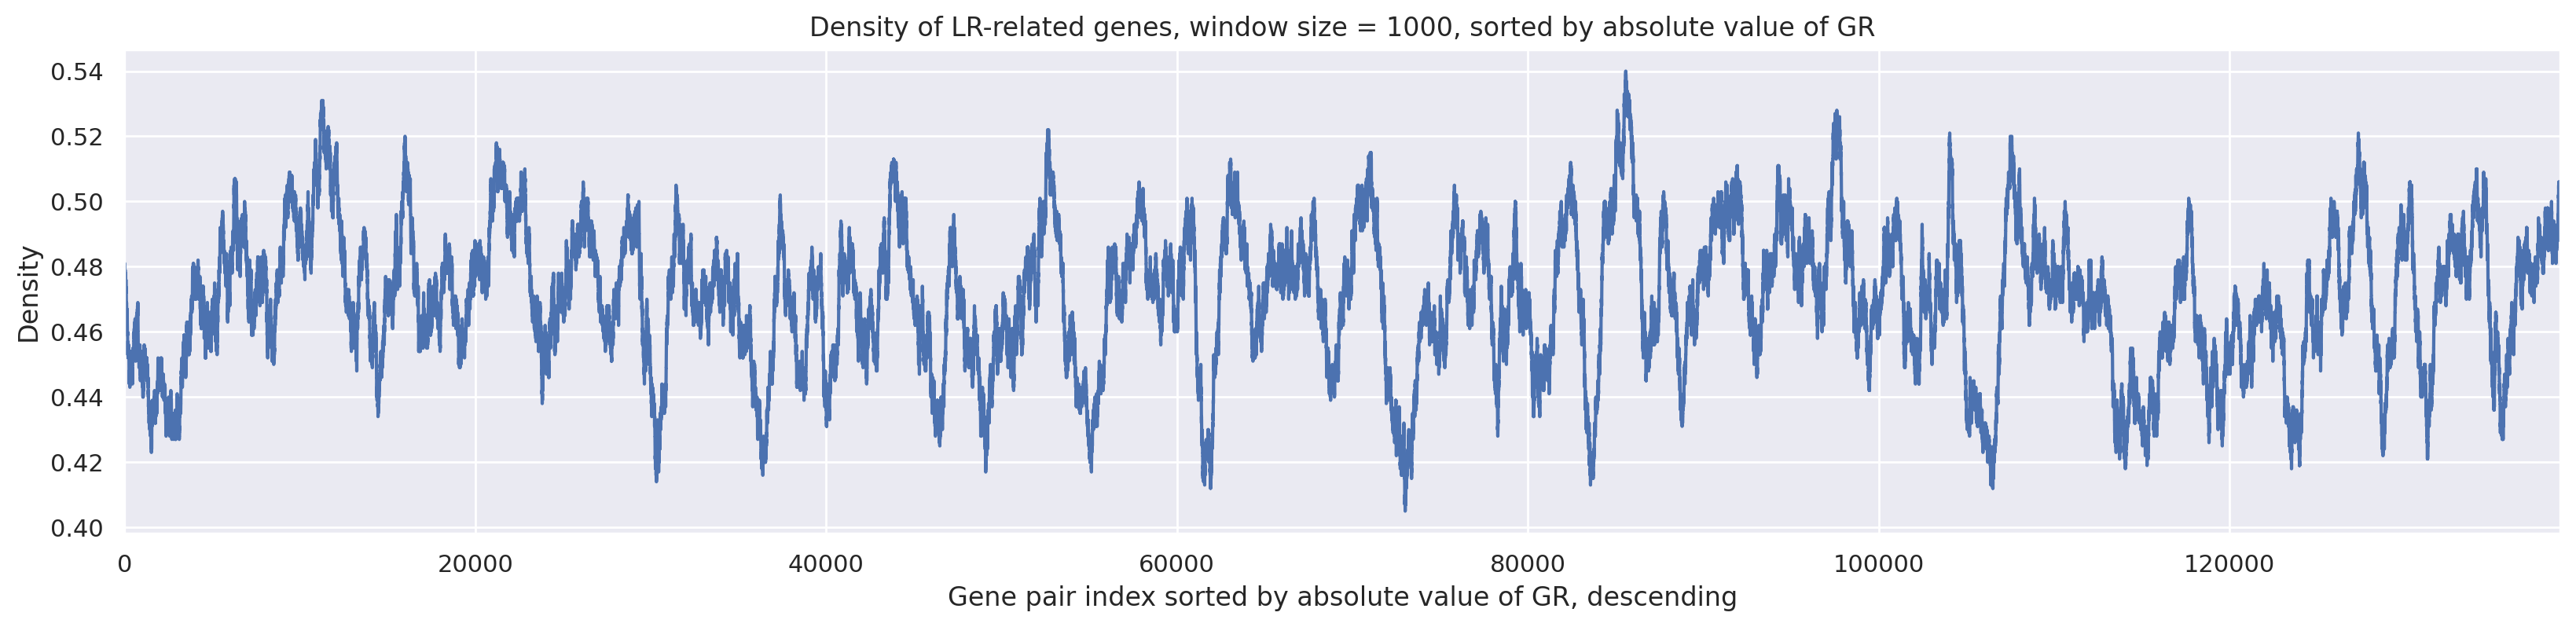

In [22]:
ranked_indices = np.argsort(np.abs(matGR), axis=None)
ranked_indices = np.unravel_index(ranked_indices, matGR.shape)

LR_related_genes = set(lgID) | set(rpID)

hasRelatedGenes = []

for indices in zip(ranked_indices[0], ranked_indices[1]):
    cnt = 0
    if adata.var.index[indices[0]] in LR_related_genes:
        cnt += 1
    if adata.var.index[indices[1]] in LR_related_genes:
        cnt += 1
    hasRelatedGenes.append(cnt)

hasRelatedGenes = np.array(hasRelatedGenes)

WINDOW_SIZE = 1000

density = []

for i in range(len(hasRelatedGenes) - WINDOW_SIZE):
    density.append(np.mean(hasRelatedGenes[i:i + WINDOW_SIZE]))
    
%config InlineBackend.figure_format ='retina'
sns.set()
plt.figure(figsize=(20, 4));
plt.plot(density);
plt.title(f'Density of LR-related genes, window size = {WINDOW_SIZE}, sorted by absolute value of GR');
plt.xlim(0, len(hasRelatedGenes) - WINDOW_SIZE);
plt.xlabel('Gene pair index sorted by absolute value of GR, descending');
plt.ylabel('Density');

In [23]:
genesCol = adata.var_names[meaningfulCols]
genesRow = adata.var_names[meaningfulRows]

genesCol, genesRow

(Index(['ENSMUSG00000018381', 'ENSMUSG00000035783', 'ENSMUSG00000020178',
        'ENSMUSG00000024397', 'ENSMUSG00000060802', 'ENSMUSG00000031375',
        'ENSMUSG00000021835', 'ENSMUSG00000028487', 'ENSMUSG00000036887',
        'ENSMUSG00000036896',
        ...
        'ENSMUSG00000024610', 'ENSMUSG00000019880', 'ENSMUSG00000026083',
        'ENSMUSG00000055415', 'ENSMUSG00000031839', 'ENSMUSG00000025357',
        'ENSMUSG00000055761', 'ENSMUSG00000050711', 'ENSMUSG00000097648',
        'ENSMUSG00000024501'],
       dtype='object', length=183),
 Index(['ENSMUSG00000018381', 'ENSMUSG00000035783', 'ENSMUSG00000024411',
        'ENSMUSG00000031375', 'ENSMUSG00000021835', 'ENSMUSG00000028487',
        'ENSMUSG00000036887', 'ENSMUSG00000045532', 'ENSMUSG00000073418',
        'ENSMUSG00000003657',
        ...
        'ENSMUSG00000026083', 'ENSMUSG00000055415', 'ENSMUSG00000041959',
        'ENSMUSG00000028370', 'ENSMUSG00000031839', 'ENSMUSG00000045875',
        'ENSMUSG00000040612', 'ENSM

In [24]:
meaningfulMatGR.shape

(183, 183)

([<matplotlib.axis.YTick at 0x7f748ef4d990>,
 [Text(0, 0, 'ENSMUSG00000039579'),
  Text(0, 1, 'ENSMUSG00000035273'),
  Text(0, 2, 'ENSMUSG00000018381'),
  Text(0, 3, 'ENSMUSG00000061911'),
  Text(0, 4, 'ENSMUSG00000069132'),
  Text(0, 5, 'ENSMUSG00000032691'),
  Text(0, 6, 'ENSMUSG00000016763'),
  Text(0, 7, 'ENSMUSG00000097623'),
  Text(0, 8, 'ENSMUSG00000034855'),
  Text(0, 9, 'ENSMUSG00000031839')])

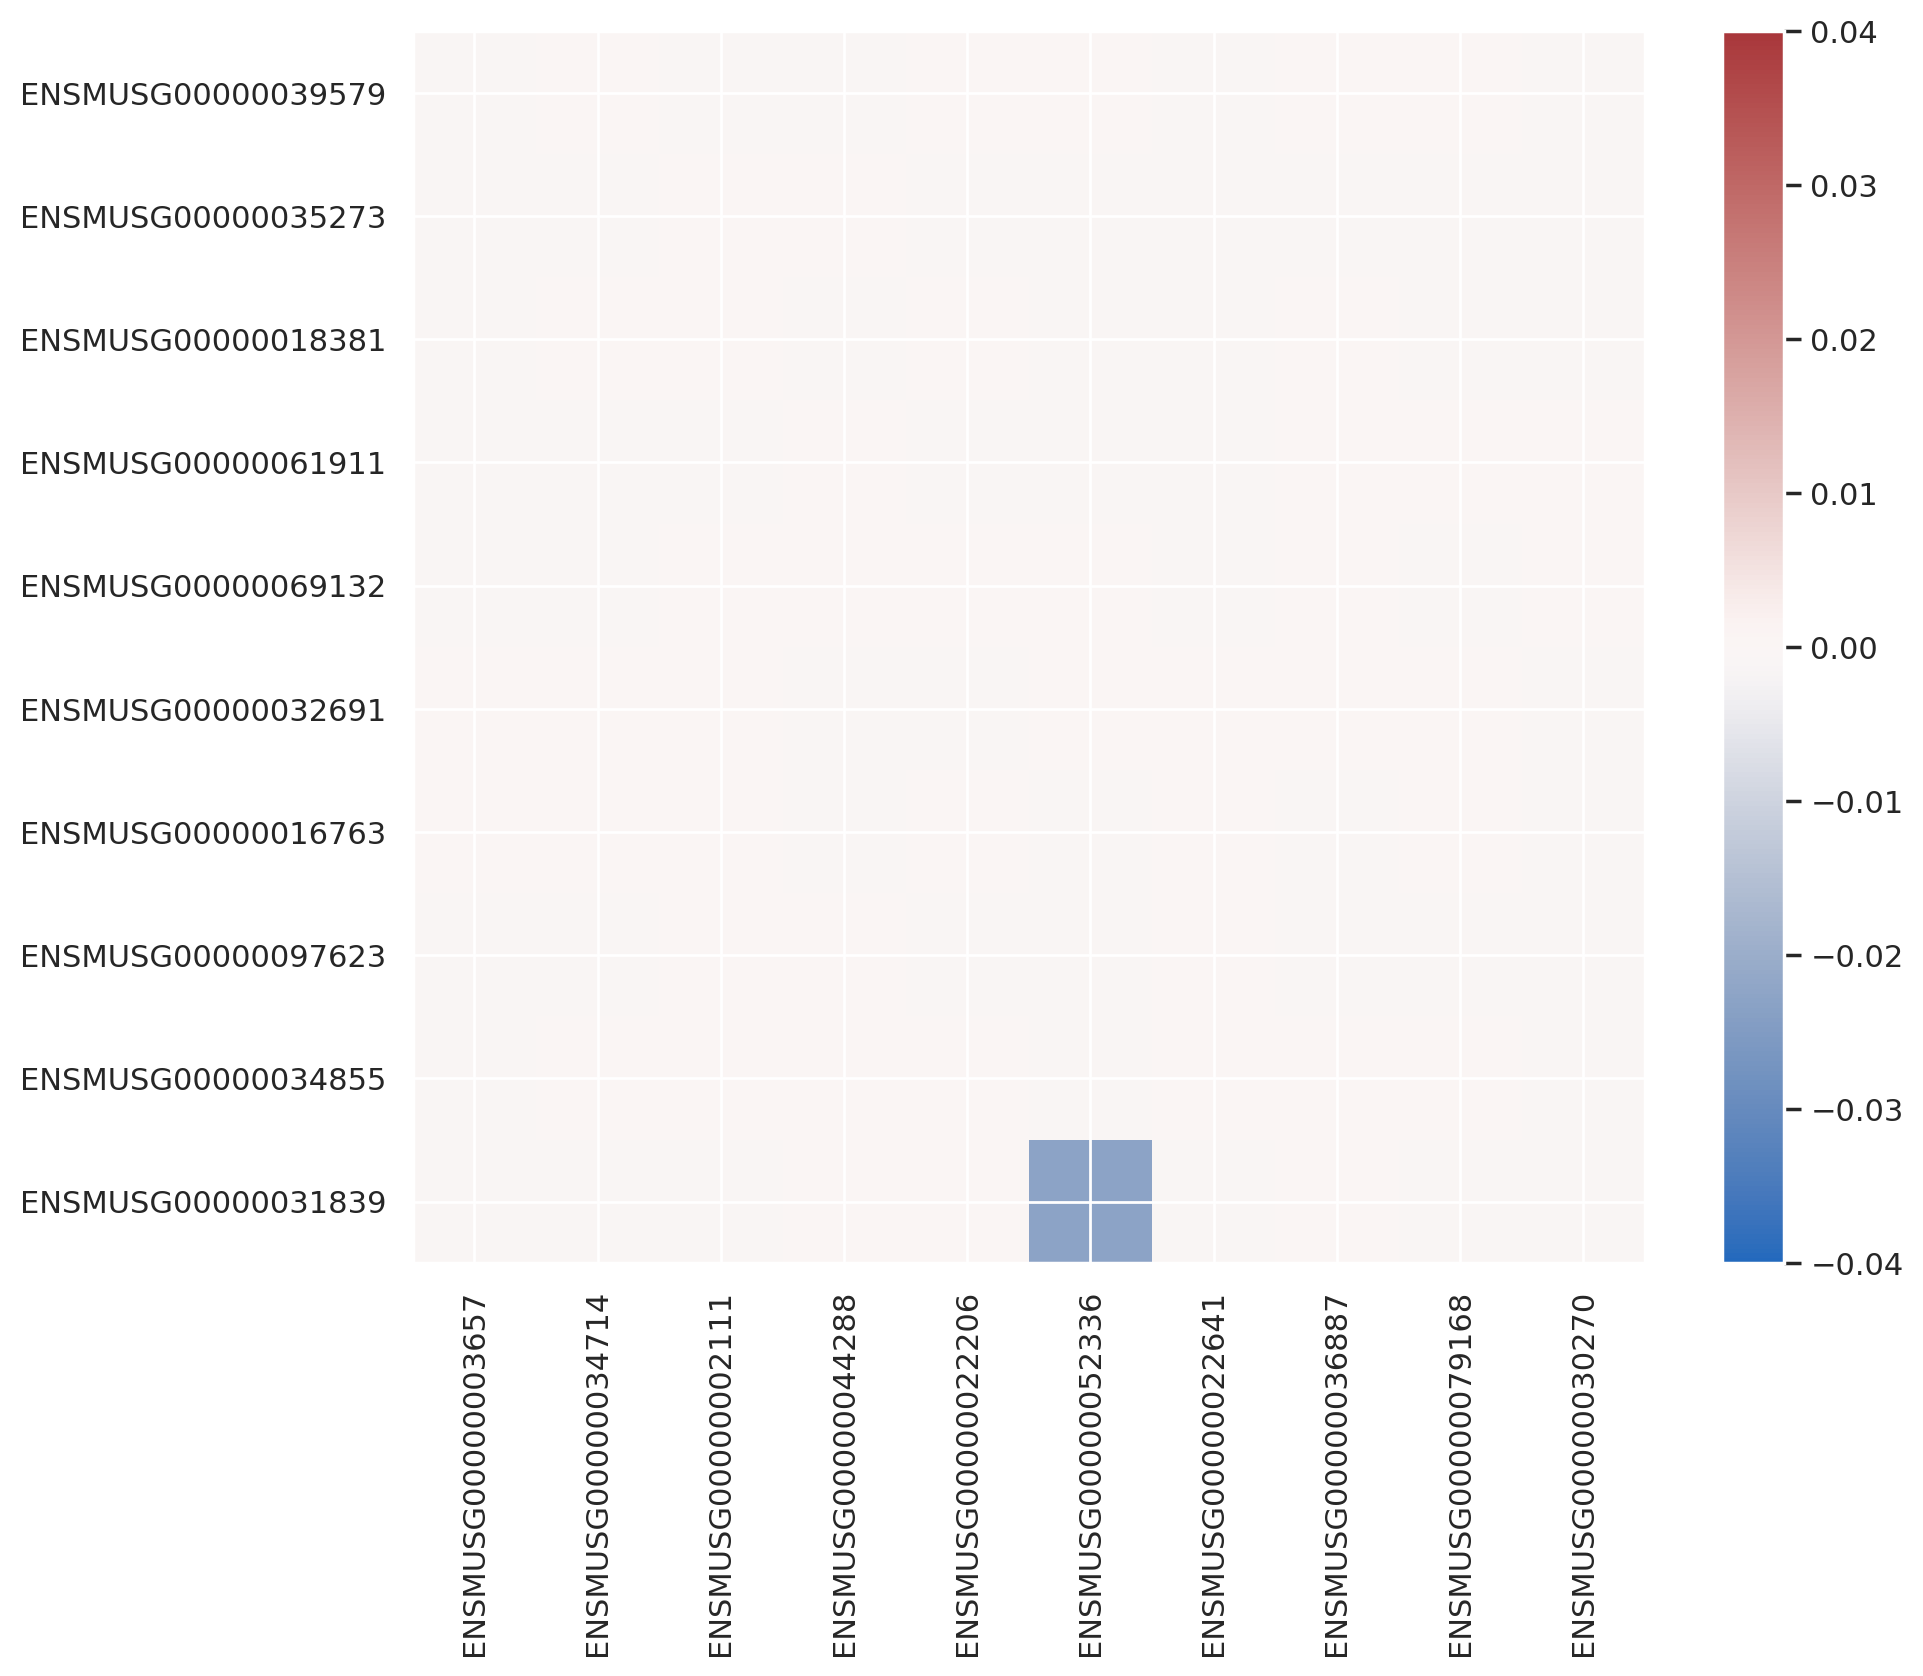

In [25]:
# take out a random patch

PATCH_SIZE = 10

idxCol = np.random.choice(meaningfulMatGR.shape[1], size=PATCH_SIZE, replace=False)
idxRow = np.random.choice(meaningfulMatGR.shape[0], size=PATCH_SIZE, replace=False)

patchMatGR = meaningfulMatGR[idxRow, :][:, idxCol]
patchGeneCol = genesCol[idxCol]
patchGeneRow = genesRow[idxRow]

plt.figure(figsize=(10, 8))
plt.imshow(patchMatGR, cmap='vlag', vmin=-.04, vmax=.04)
plt.colorbar()
plt.xticks(range(PATCH_SIZE), patchGeneCol, rotation=90)
plt.yticks(range(PATCH_SIZE), patchGeneRow)

In [27]:
C = model.cell_interacts[head].transform.data.detach().cpu().numpy()

embeddingsTrf = []
for Xs in train_Xs:
    embeddingsTrf.append(model.getCellEmbedding(Xs[None, :, :])[0])
    
cellInteractions = []

for embeddingTrf in embeddingsTrf:
    cellInteractions.append(embeddingTrf @ C @ embeddingTrf.T)

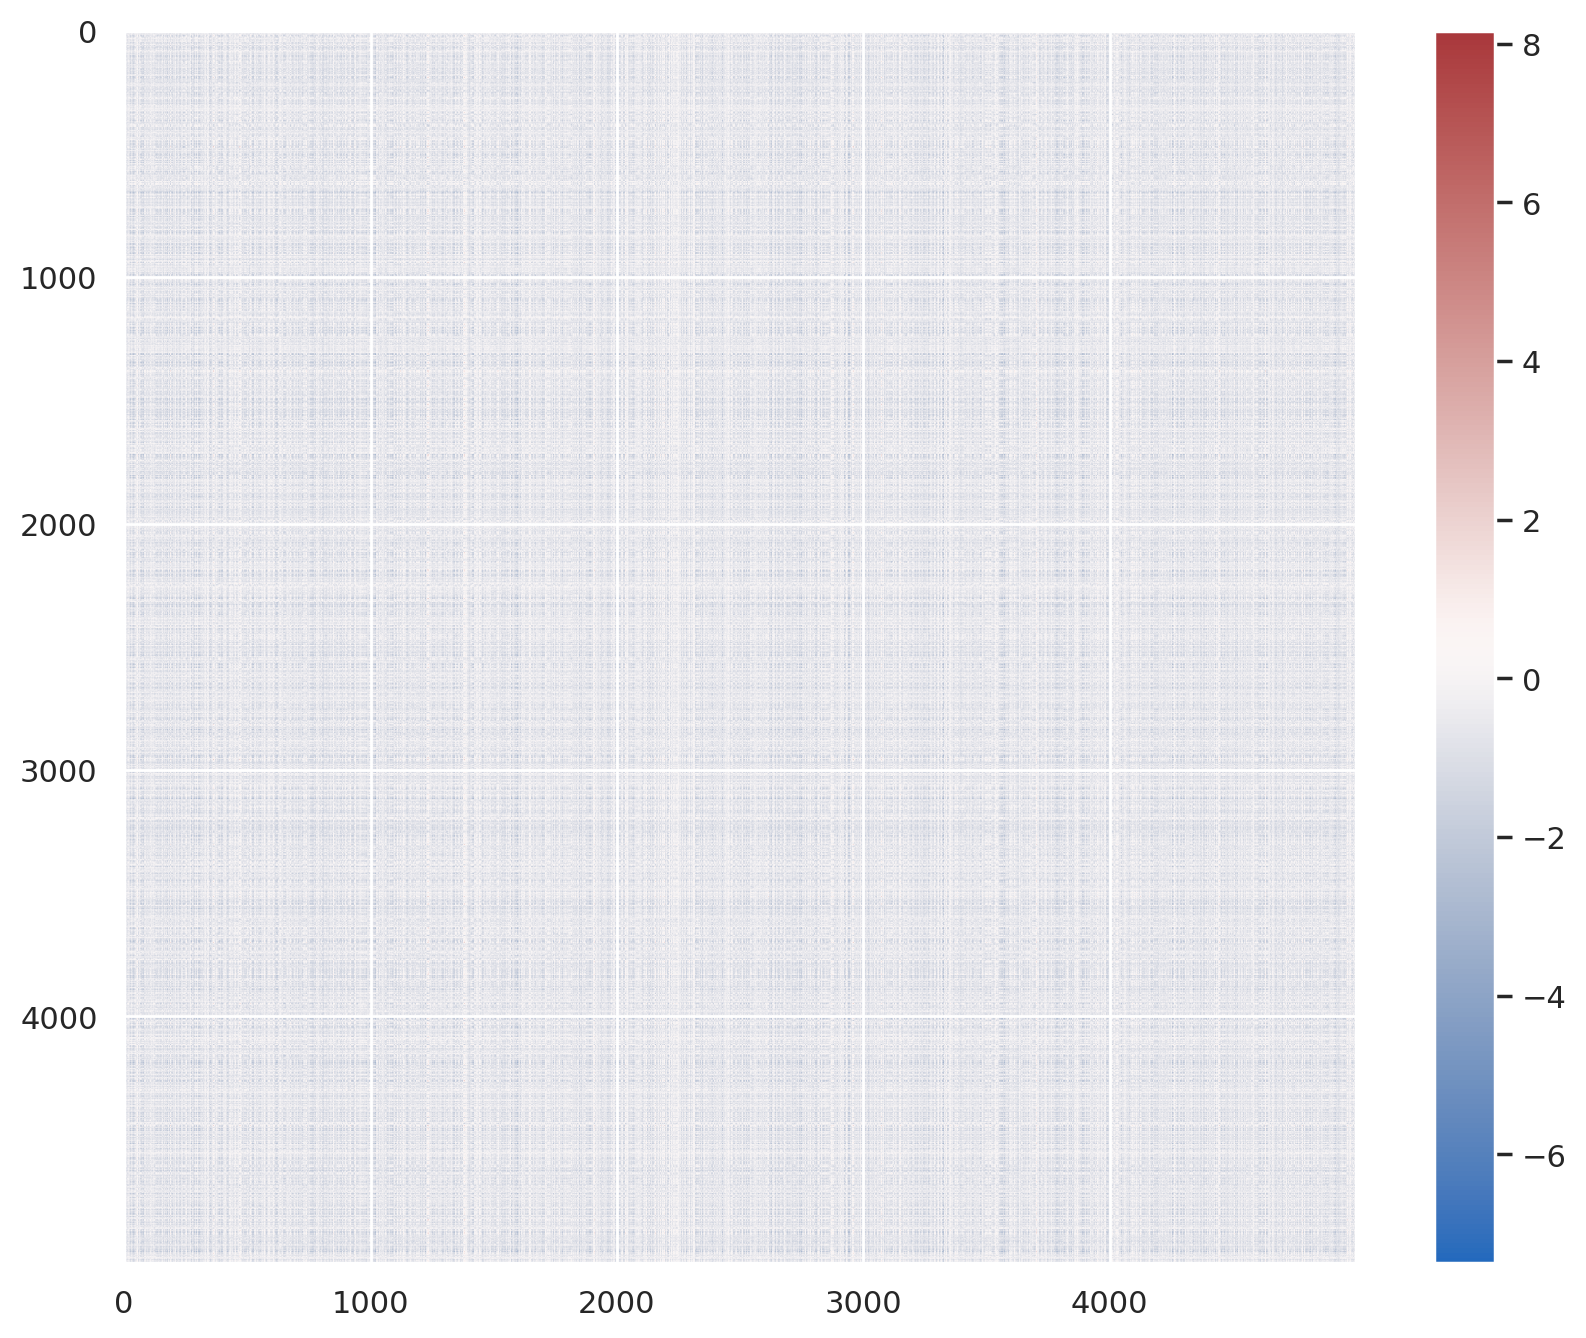

In [29]:
# plot heatmap of cell interactions[0]

plt.figure(figsize=(10, 8))
plt.imshow(cellInteractions[0], cmap='vlag')
plt.colorbar()


In [30]:
pairwiseDistances = np.zeros_like(cellInteractions[0])

adataOfInterest = adata[adata.obs['donor_slice'] == 'MsBrainAgingSpatialDonor_5_0']
adataOfInterest

/home/caoyufan/miniconda3/envs/kuanglu/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


View of AnnData object with n_obs × n_vars = 5000 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'donor_slice'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'batch_condition', 'cell_type_annot_colors', 'cell_type_colors', 'donor_id_colors', 'schema_version', 'title'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'spatial'

In [59]:
xCor = np.array(adataOfInterest.obs['center_x'])
yCor = np.array(adataOfInterest.obs['center_y'])

xCor = [eval(x) for x in xCor]
yCor = [eval(y) for y in yCor]

xCor = np.array(xCor)[:, None]
yCor = np.array(yCor)[:, None]

In [64]:
pairwiseDistances = (((xCor - xCor.T) / 100.) ** 2 + ((yCor - yCor.T) / 100.) ** 2) ** .5

Text(0.5, 1.0, 'Cell interaction vs pairwise distance')

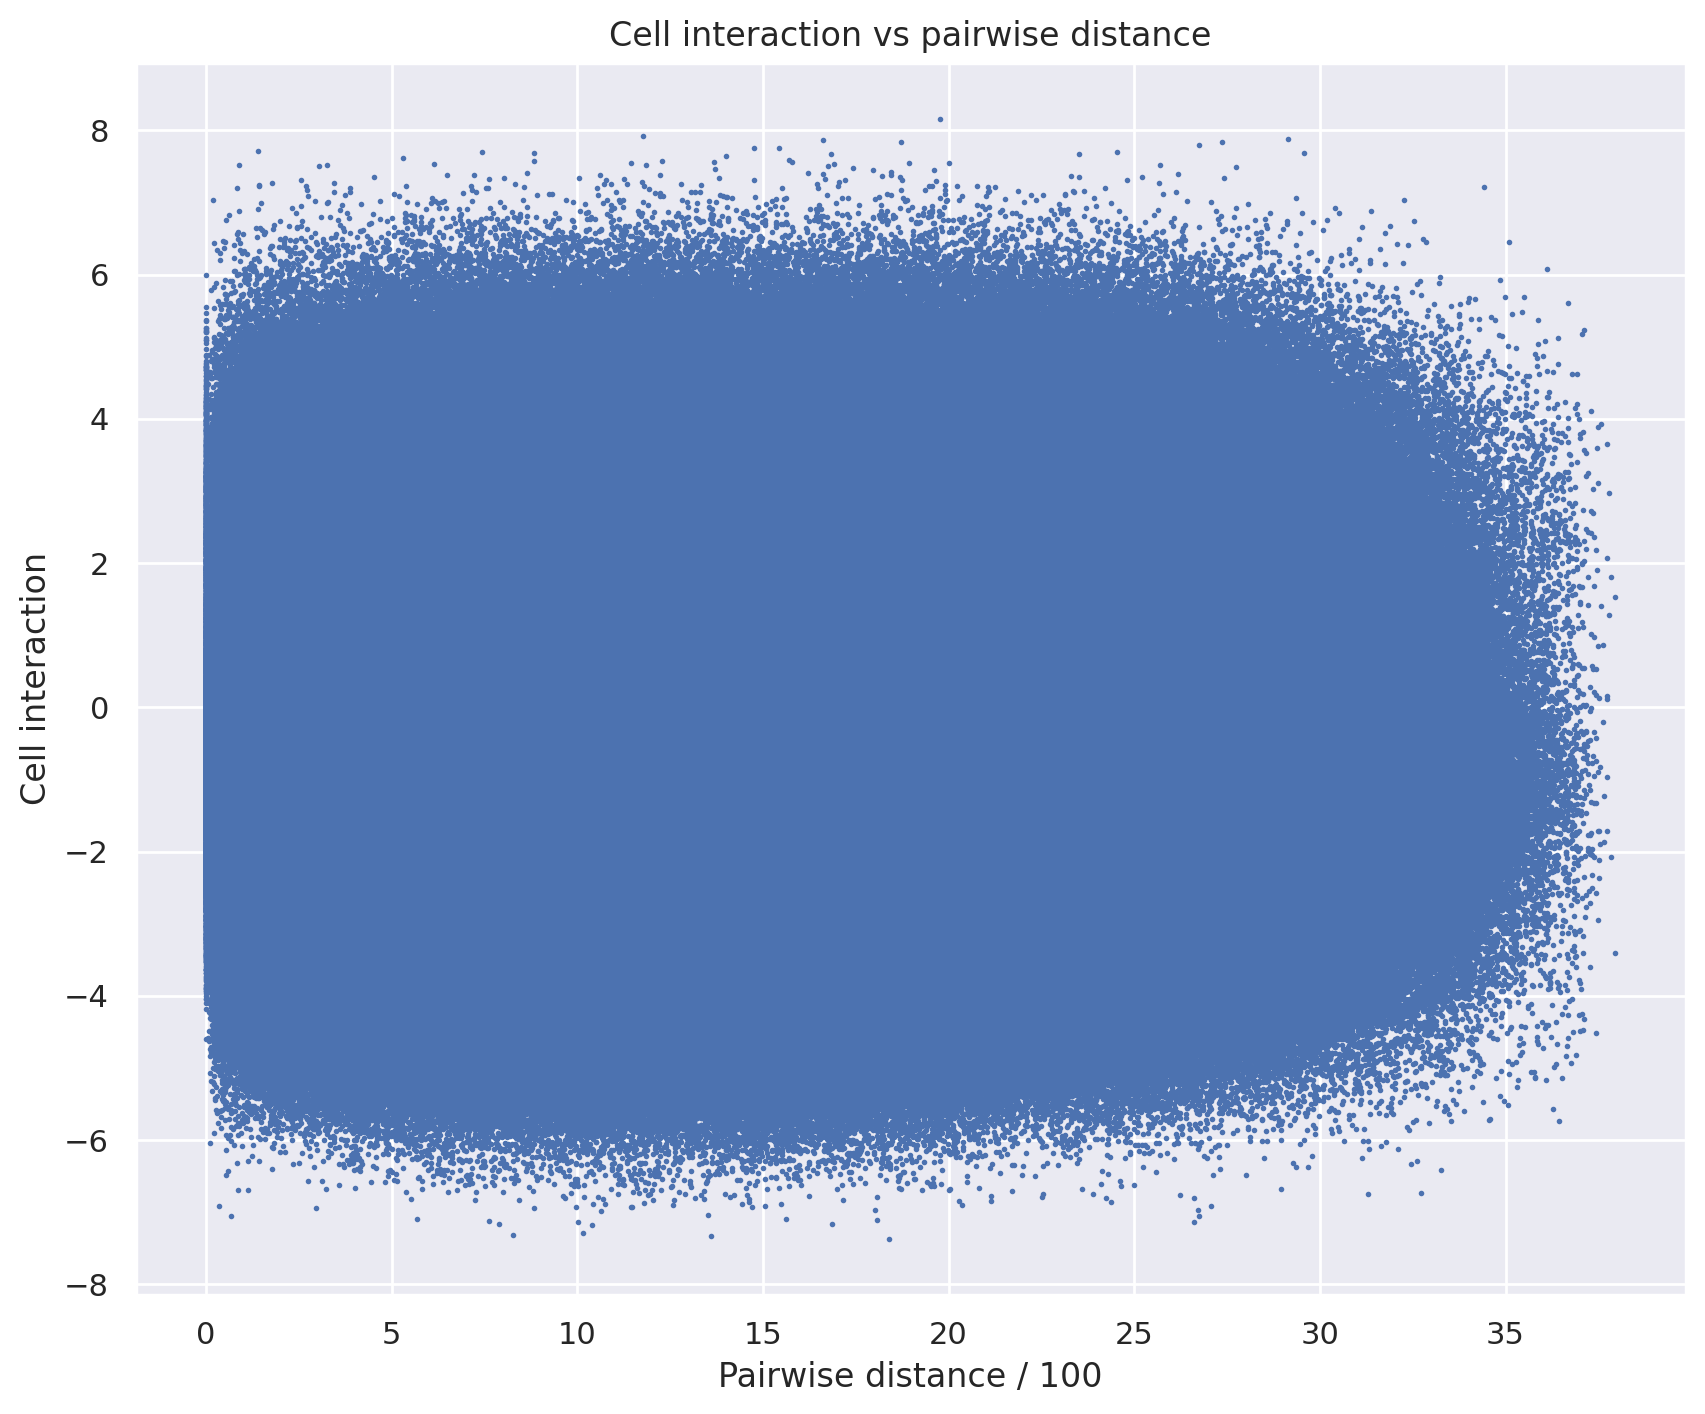

In [66]:
cellInteractionsPlot = cellInteractions[0].flatten()
pairwiseDistancesPlot = pairwiseDistances.flatten()

plt.figure(figsize=(10, 8))
plt.scatter(pairwiseDistancesPlot, cellInteractionsPlot, s=1)
plt.xlabel('Pairwise distance / 100')
plt.ylabel('Cell interaction')
plt.title('Cell interaction vs pairwise distance')


In [67]:
# Do a KDE plot

from scipy.stats import gaussian_kde

x = pairwiseDistancesPlot
y = cellInteractionsPlot

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=z, s=1)
plt.xlabel('Pairwise distance / 100')
plt.ylabel('Cell interaction')
plt.title('Cell interaction vs pairwise distance')
